In [1]:
# Deep Learning Quick Reference Chapter 5: Multiclass Classification
# Mike Bernico <mike.bernico@gmail.com>

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_mnist():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    #평탄화
    train_X = train_X.reshape(-1, 784)
    test_X = test_X.reshape(-1, 784)
    # scaler
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X /= 255
    test_X /= 255
    #종속변수벡터 --> 범주형 벡터로 전환
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    #dataset 분리
    return {"train_X": train_X[:55000, :], "train_y": train_y[:55000, :],
            "val_X": train_X[55000:, :], "val_y": train_y[55000:, :], "test_X": test_X, "test_y": test_y}

In [3]:
def build_network(input_features=None):
    # first we specify an input layer, with a shape == features
    inputs = Input(shape=(input_features,), name="input")
    x = Dense(512, activation='relu', name="hidden1")(inputs)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', name="hidden2")(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', name="hidden3")(x)
    x = Dropout(0.5)(x)
    prediction = Dense(10, activation='softmax', name="output")(x)
    model = Model(inputs=inputs, outputs=prediction)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [4]:
def create_callbacks():
    tensorboard_callback = TensorBoard(log_dir=os.path.join(os.getcwd(), "tb_log", "mnist_512_256_128_dropout"), histogram_freq=1, batch_size=32,
                                       write_graph=True, write_grads=False)
      # tensorboard --logdir /tf/keras_park/Deep-Learning-Quick-Reference-master/Chapter05/tb_log --port 6666 --bind_all
        
    checkpoint_callback = ModelCheckpoint(filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", monitor='val_accuracy', #val_acc
                                          verbose=0, save_best_only=True)
    return [tensorboard_callback, checkpoint_callback]

In [5]:
def print_model_metrics(model, data):
    #model 평가(test)
    loss, accuracy = model.evaluate(x=data["test_X"], y=data["test_y"])
    print("\n model test loss is "+str(loss)+" accuracy is "+str(accuracy))

    #metric
    y_softmax = model.predict(data["test_X"])  # this is an n x class matrix of probabilities
    y_hat = y_softmax.argmax(axis=-1)  # this will be the class number.
    test_y = data["test_y"].argmax(axis=-1)  # our test data is also categorical
    print(classification_report(test_y, y_hat))

    # 영상입력 다중분류 모델사용하기(실제손글씨 판정결과 plt)   <======   model.add(Dense(10, activation='softmax'))
    width = 28
    height = 28
    plt_row = 5
    plt_col = 5
    plt.rcParams["figure.figsize"] = (10,10)
    f, axarr = plt.subplots(plt_row, plt_col)
    cnt = 0
    i = 0
    j = []
    while cnt < (plt_row*plt_col):
        if np.argmax(data["test_y"][i]) == np.argmax(y_softmax[i]):
            i += 1
            continue
        sub_plt = axarr[cnt//plt_row, cnt%plt_col]
        sub_plt.axis('off')
        sub_plt.imshow(data["test_X"][i].reshape(width, height))
        sub_plt_title = 'R: ' + str(np.argmax(data["test_y"][i])) + ' P: ' + str(np.argmax(y_softmax[i]))
        sub_plt.set_title(sub_plt_title)
        j.append(i)

        i += 1    
        cnt += 1

    print(f'\ntest {len(y_softmax)}중에서 틀린 개수 : {cnt}')
    print(f'틀린 index : {j}')

    plt.show()

In [10]:
# 모델 학습과정 살펴보기
def plt_model_process(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 0.5])
    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylim([0.8, 1.0])
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='lower left')
    acc_ax.legend(loc='upper left')
    plt.show() 
    # tensorboard --logdir /tf/keras_park/Deep-Learning-Quick-Reference-master/Chapter05/tb_log --port 6666 --bind_all

In [7]:
data = load_mnist()
callbacks = create_callbacks()
model = build_network(data["train_X"].shape[1])
hist=model.fit(x=data["train_X"], y=data["train_y"],
          batch_size=30,
          epochs=50,
          validation_data=(data["val_X"], data["val_y"]),
          verbose=1,
          callbacks=callbacks)

11493376/11490434 [==============================] - 4s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
 1500/55000 [..............................] - ETA: 1:52 - loss: 2.0428 - accuracy: 0.2993

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


55000/55000 [==============================] - 11s 192us/step - loss: 0.4707 - accuracy: 0.8610 - val_loss: 0.1173 - val_accuracy: 0.9638
Epoch 2/50
55000/55000 [==============================] - 7s 132us/step - loss: 0.2352 - accuracy: 0.9357 - val_loss: 0.0859 - val_accuracy: 0.9748
Epoch 3/50
55000/55000 [==============================] - 7s 131us/step - loss: 0.1957 - accuracy: 0.9453 - val_loss: 0.0727 - val_accuracy: 0.9794
Epoch 4/50
55000/55000 [==============================] - 7s 132us/step - loss: 0.1730 - accuracy: 0.9530 - val_loss: 0.0797 - val_accuracy: 0.9772
Epoch 5/50
55000/55000 [==============================] - 6s 115us/step - loss: 0.1563 - accuracy: 0.9576 - val_loss: 0.0833 - val_accuracy: 0.9766
Epoch 6/50
55000/55000 [==============================] - 7s 123us/step - loss: 0.1431 - accuracy: 0.9610 - val_loss: 0.0695 - val_accuracy: 0.9802
Epoch 7/50
55000/55000 [==============================] - 7s 129us/step - loss: 0.1375 - accuracy: 0.9631 - val_loss: 0.06

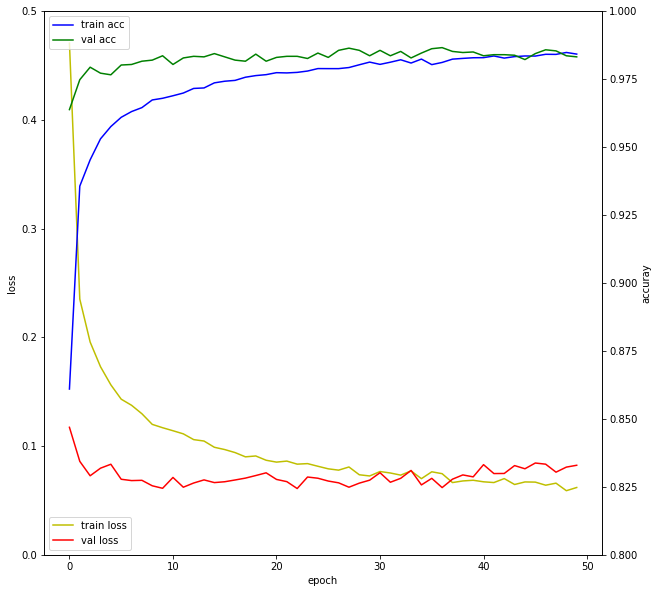

In [11]:
# 모델 학습과정 살펴보기
plt_model_process(hist)

10000/10000 [==============================] - 0s 29us/step

 model test loss is 0.11589556544320405 accuracy is 0.9807000160217285
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


test 10000중에서 틀린 개수 : 25
틀린 index : [149, 247, 320, 321, 359, 381, 582, 583, 619, 691, 717, 720, 740, 844, 8

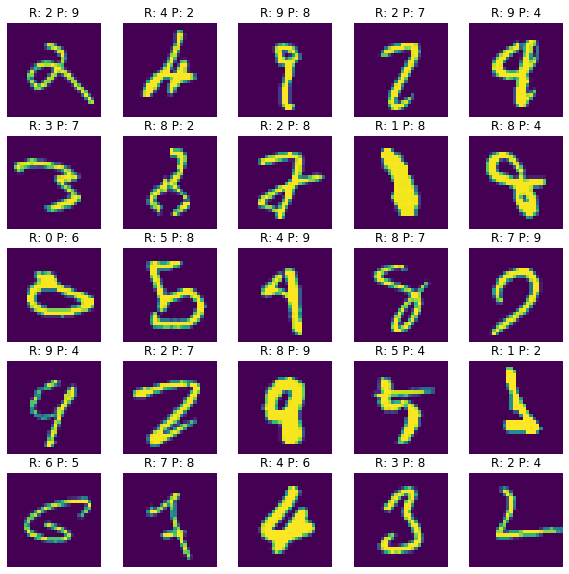

In [9]:
# 모델 평가
print_model_metrics(model, data)